In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm
from matplotlib import pyplot as plt

import math
import random

from config import client
from dataset import BeatmapSamples, BeatmapDataset, ShufflePairs
from model import Siamese
from pytorchtools import EarlyStopping
from utils import Stopwatch

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
osu_db = client['osu_mlpp_db1']

In [6]:
TRAIN_REGRESSION = False
N = 1000
RATIO_MIN = 1.5

MODEL_PATH = f"{'regression' if TRAIN_REGRESSION else 'binary'}_N{N}_rm{RATIO_MIN}.pt"

sample = BeatmapSamples(
    osu_db.osu_beatmaps, 
    osu_db.mlpp_failtimes_experiment, 
    N, 
    probability=TRAIN_REGRESSION,
    ratio_min = RATIO_MIN,
    fail_min= 1000, 
    drain_min = 3
)

sample.clear_out()
sample.generate()

100%|██████████| 1000/1000 [00:27<00:00, 36.10it/s]


In [7]:
train_dataset, test_dataset = BeatmapDataset.split(osu_db.mlpp_failtimes_experiment, .8)

In [8]:
learning_rate = .001
batch_size = 32
num_epochs = 100

In [9]:
train_loader = DataLoader(train_dataset, batch_size=batch_size)
valid_loader = DataLoader(test_dataset, batch_size=batch_size)

timer = Stopwatch()
early_stopping = EarlyStopping(path=MODEL_PATH)

n_total_steps = math.ceil(len(train_dataset) / batch_size)

model = Siamese().to(device)

criterion = nn.MSELoss() if TRAIN_REGRESSION else nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

avg_train_losses = []
avg_valid_losses = []

for epoch in range(num_epochs):
    timer.start()
    
    train_losses = []
    valid_losses = []
    
    model.train()
    for i, (x1, x2, labels) in enumerate(train_loader):
        
        x1 = x1.to(device)
        x2 = x2.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(x1, x2)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
    
    model.eval()
    for x1, x2, labels in valid_loader:
        
        x1 = x1.to(device)
        x2 = x2.to(device)
        labels = labels.to(device)
        
        outputs = model(x1, x2)
        loss = criterion(outputs, labels)
        
        valid_losses.append(loss.item())
    
    train_loss = np.average(train_losses)
    valid_loss = np.average(valid_losses)
    
    avg_train_losses.append(train_loss)
    avg_valid_losses.append(valid_loss)
    
    timer.stop()
    
    if (epoch + 1) % 10 == 0: 
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}, Time: {timer.elapsed:.2f}s')
    
    timer.reset()
    
    early_stopping(valid_loss, model)
    
    if early_stopping.early_stop:
        print("Stopping")
        break


EarlyStopping counter: 1 out of 7
EarlyStopping counter: 2 out of 7
EarlyStopping counter: 3 out of 7
Epoch [10/100], Train Loss: 0.4875, Valid Loss: 0.5169, Time: 1.30s
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 2 out of 7
EarlyStopping counter: 3 out of 7
EarlyStopping counter: 4 out of 7
EarlyStopping counter: 5 out of 7
Epoch [20/100], Train Loss: 0.4647, Valid Loss: 0.5153, Time: 1.35s
EarlyStopping counter: 6 out of 7
EarlyStopping counter: 7 out of 7
Stopping


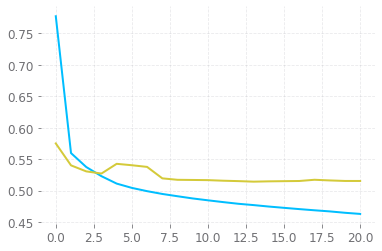

In [10]:
from matplotlib import pyplot as plt
plt.plot(avg_train_losses)
plt.plot(avg_valid_losses)

In [63]:
model.load_state_dict(torch.load("binary_N1000_rm1.5.pt"))

<All keys matched successfully>

In [50]:
sample = BeatmapSamples(osu_db.osu_beatmaps, osu_db.mlpp_failtimes_control, 1000, ratio_min = 1.5, fail_min=1000, drain_min = 3)
sample.clear_out()
sample.generate()

100%|██████████| 1000/1000 [00:25<00:00, 38.54it/s]


In [51]:
full_dataset = BeatmapDataset(osu_db.mlpp_failtimes_control)
full_loader = DataLoader(full_dataset, batch_size=batch_size)

In [64]:
out_all = []
out1_all = []

with torch.no_grad():
    n_samples = 0
    n_correct = 0
    
    for X1, X2, Y in full_loader:

        X1 = X1.to(device)
        X2 = X2.to(device)
        Y = torch.round(Y).to(device)
        
        out1 = model.forward_one(X1)
        out = model.forward(X1, X2)
        predicted = torch.round(out)

        n_samples += Y.size(0)
        n_correct += (Y == predicted).type(torch.float32).sum().item()
        
        out_all.extend(out.squeeze().tolist())
        out1_all.extend(out1.squeeze().tolist())

out_all = torch.tensor(out_all)
out1_all = torch.tensor(out1_all)

print(n_correct/n_samples)

0.7649811984958796


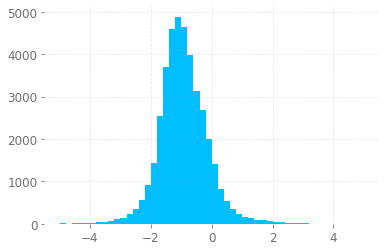

In [46]:
_ = plt.hist(out1_all.tolist(), range=(-5, 5), bins=50)

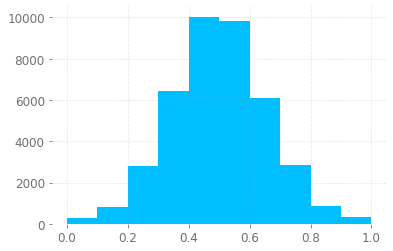

In [47]:
_ = plt.hist(out_all.tolist())

In [48]:
pred_all = torch.round(out_all)
print(pred_all.mean(), pred_all.std())

tensor(0.4949) tensor(0.5000)
